Павлов Роман КІ-31мп

Додамо відповідні бібліотеки

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import cv2
from matplotlib import pyplot as plt
%matplotlib inline
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Тут два варіанта функції, перше використання numpy для створення масиву, а перетворення виконуються за допомогою елементарних алгоритмів.
У другій використовуються методи numpy, а підсумовування за допомогу підсумовування Енштейна.

In [2]:
def conv2d_custom(matrix, core, step=1):
    size = len(matrix) - len(core)

    if size < step:
        return 0

    temp = np.zeros((len(core), len(core[0])))
    result = np.zeros((size // step + 1, size // step + 1))

    for i_re in range(0, size + step, step):
        for j_re in range(0, size + step, step):
            for i in range(len(core)):
                for j in range(len(core[i])):
                    temp[i][j] = matrix[i + i_re][j + j_re] * core[i][j]
            result[i_re // step][j_re // step] = sum(sum(temp))

    return result

def conv2dnp(matrix, core):
    s = core.shape + tuple(np.subtract(matrix.shape, core.shape) + 1)
    strd = np.lib.stride_tricks.as_strided
    subM = strd(matrix, shape=s, strides=matrix.strides * 2)
    return np.einsum('ij,ijkl->kl', core, subM)

Завантажуемо зображення

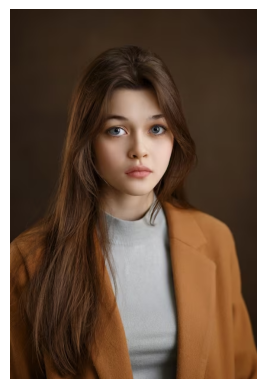

In [3]:
img_p = cv2.imread('girlphoto.png')
img = cv2.cvtColor(img_p, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis('off')
plt.show()

Функція multi_conv реалізує застусування матриці згортки на зображення по кольорам.
Тут застосуємо матрицю гаусса 3х3, але матриця можебути і іншою.

In [4]:
gaussian_filter = tf.constant([[[[1.0, 2.0, 1.0],
                               [2.0, 4.0, 2.0],
                               [1.0, 2.0, 1.0]]]], dtype=tf.float32)
gaussian_filter = gaussian_filter / tf.reduce_sum(gaussian_filter)
gaussian_filter = tf.transpose(gaussian_filter, perm=[2, 3, 0, 1])

def multi_conv(image, filter_kernal):
    image = cv2.imread('girlphoto.png')

    red_image, green_image, blue_image = cv2.split(image)
    
    blue_image_tf = tf.convert_to_tensor(blue_image, dtype=tf.float32)
    green_image_tf = tf.convert_to_tensor(green_image, dtype=tf.float32)
    red_image_tf = tf.convert_to_tensor(red_image, dtype=tf.float32)
    
    conv_blue = tf.nn.conv2d(blue_image_tf[None, ..., None], gaussian_filter, strides=[1, 1, 1, 1], padding='SAME')
    conv_red = tf.nn.conv2d(red_image_tf[None, ..., None], gaussian_filter, strides=[1, 1, 1, 1], padding='SAME')
    conv_green = tf.nn.conv2d(green_image_tf[None, ..., None], gaussian_filter, strides=[1, 1, 1, 1], padding='SAME')
    
    conv_blue = tf.squeeze(conv_blue)
    conv_green = tf.squeeze(conv_green)
    conv_red = tf.squeeze(conv_red)

    merged_image = cv2.merge((conv_blue.numpy().astype(np.uint8), conv_green.numpy().astype(np.uint8), conv_red.numpy().astype(np.uint8)))
    
    return merged_image

Застусуємо функцію та виведемо зображення.

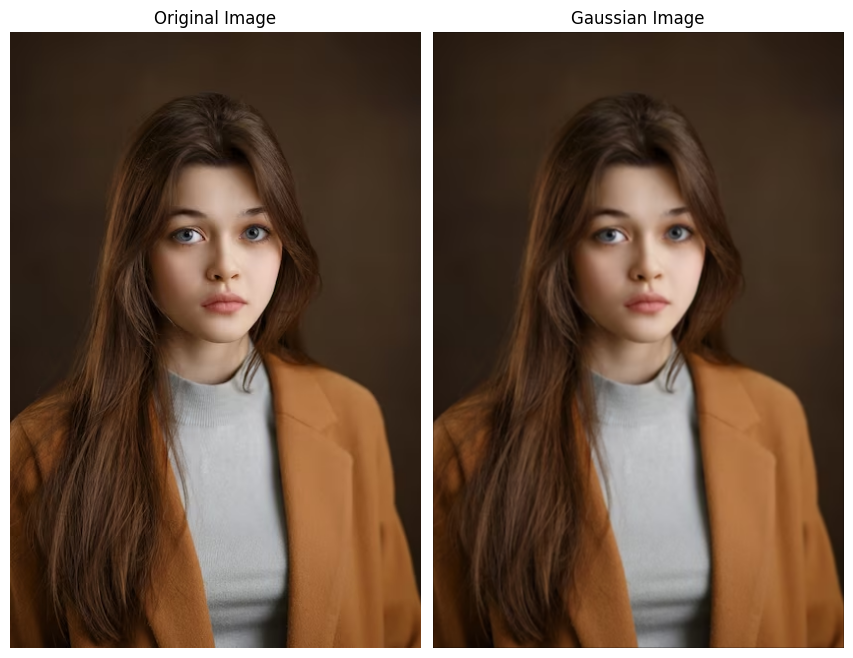

In [5]:
gauss_image = multi_conv(img, gaussian_filter)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 1, 1)
plt.title('Gaussian Image')
plt.imshow(gauss_image)
plt.axis('off')

plt.show()

Перетворюємо зображення до тензору та використовуємо вже реалізовані моделі tfa і виводимо зображення з порівнянням орігіналу. Наступні пункти використовують такий ж алгоритм

In [6]:
img_tf = tf.convert_to_tensor(img, dtype=tf.float32)

In [7]:
image_gaussian_5 = tfa.image.gaussian_filter2d(img_tf, filter_shape=5)
image_gaussian_20 = tfa.image.gaussian_filter2d(img_tf, filter_shape=20)

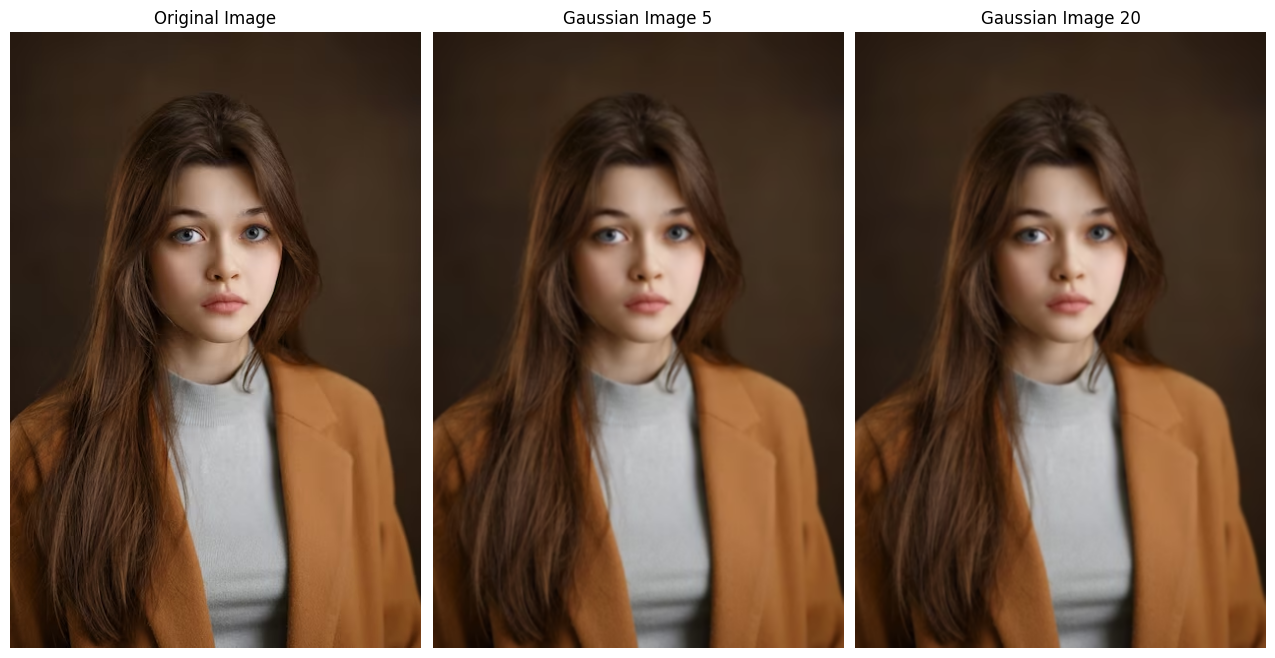

In [8]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 1, 1)
plt.title('Gaussian Image 5')
plt.imshow(image_gaussian_5.numpy().astype(np.uint8))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Gaussian Image 20')
plt.imshow(image_gaussian_20.numpy().astype(np.uint8))
plt.axis('off')

plt.show()

In [9]:
image_Box_filter = tfa.image.median_filter2d(img_tf, filter_shape=5)

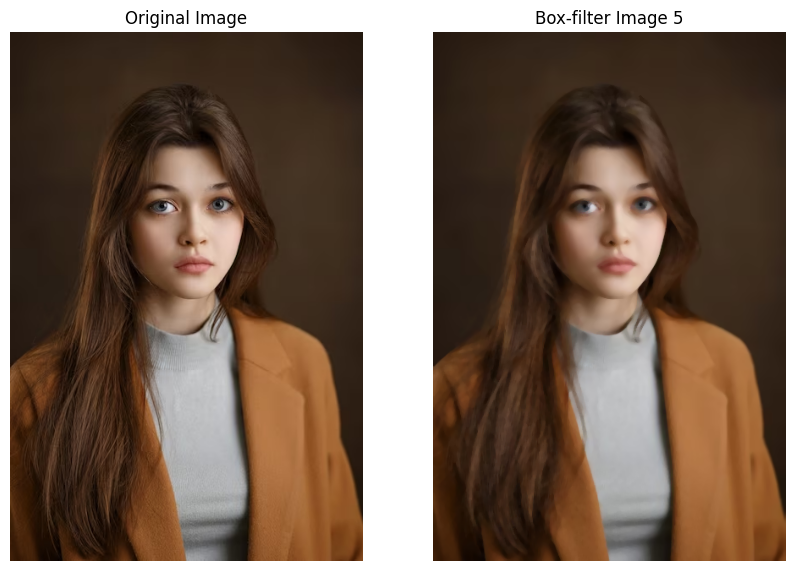

In [10]:
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Box-filter Image 5')
plt.imshow(image_Box_filter.numpy().astype(np.uint8))
plt.axis('off')

plt.show()

In [11]:
image_unsharp_masking = tfa.image.sharpness(img_tf, factor=3)

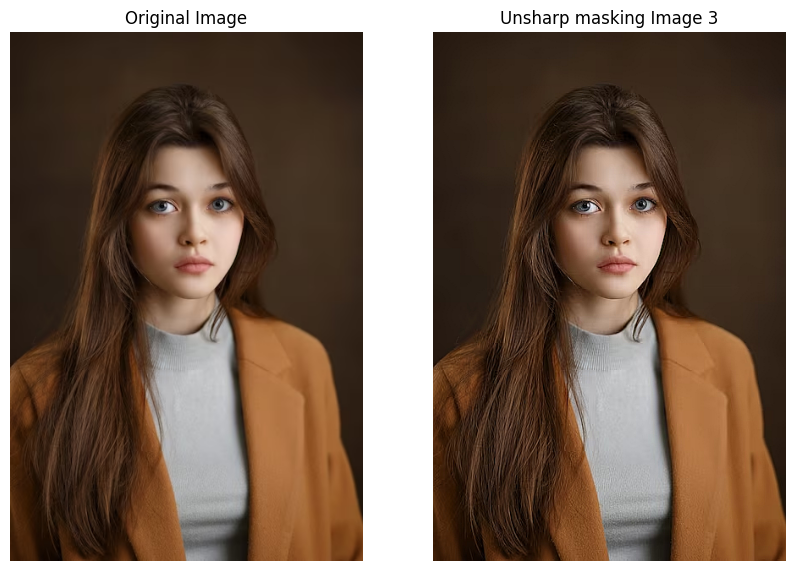

In [12]:
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Unsharp masking Image 3')
plt.imshow(image_unsharp_masking.numpy().astype(np.uint8))
plt.axis('off')

plt.show()

Використовуємо метод мін-максу до зображення то метод стандартизації.(не впевнений у корекності данної частини)

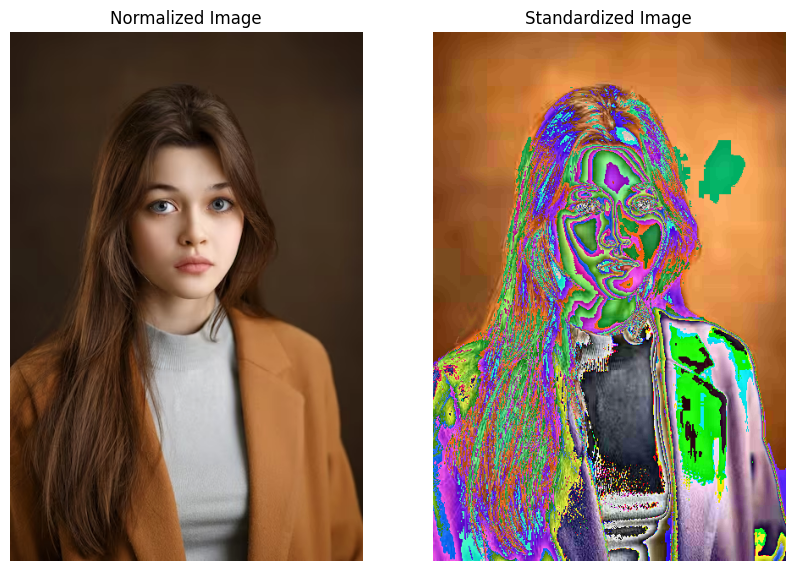

In [13]:
min_val = np.min(img_p)
max_val = np.max(img_p)
normalized_image = (img_p - min_val) / (max_val - min_val)

mean = np.mean(img_p)
std = np.std(img_p)
standardized_image = (img_p - mean) / std

normalized_image = (normalized_image * 255).astype(np.uint8)
standardized_image = (standardized_image * 255).astype(np.uint8)

normalized_image = cv2.cvtColor(normalized_image, cv2.COLOR_BGR2RGB)
standardized_image = cv2.cvtColor(standardized_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.title('Normalized Image')
plt.imshow(normalized_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Standardized Image')
plt.imshow(standardized_image)#.numpy().astype(np.uint8)
plt.axis('off')

plt.show()

Висновок:У рамках лабораторної роботи був ознайомлення з програмними iнструментами для обробки зображень, дослiдження i реалiзацiя операцiї згортки та навчитись виконувати попередню обробку зображень. Розроблено операцію згортки для обробки зображень за допомогою NumPy.
Використано OpenCV для зчитування та роботи з кольоровим зображенням.
Перетворено зображення у тензор за допомогою TensorFlow.
Застосовано фільтри Гауса, box-фільтр та unsharp masking для покращення зображення.
Досліджено варіанти нормалізації зображення, включаючи min-max та стандартизацію.